In [1]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# RDKit
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit import DataStructs


# Our module
from Python_Scoring_Export import Scoring, Export
from Python_MLModel import RF, Ridge_M, XGB, NN, CB, DT, SVR_M, KNN
from Python_RemoveO import remove_outliers

In [2]:
MF_bit = 2**12
MF_radius = 3
Name_model = "RF"
j=0

#df = pd.read_excel("../DataTb.xlsx", sheet_name="AllDataSet")
df = remove_outliers("../Data.xlsx", "New_Data", 2)
# Select feature for data: X=SMILE, Y=Tb
X_data_excel= df[["SMILES"]]
Y_data= df["Tb"] 

# Generate Fingerprint from SMILE
 
X_data_use = X_data_excel.copy()
X_data_use["molecule"] = X_data_use["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
X_data_use["count_morgan_fp"] = X_data_use["molecule"].apply(lambda x: rdMolDescriptors.GetHashedMorganFingerprint(
    x, 
    radius=MF_radius, 
    nBits=MF_bit,
    useFeatures=True, useChirality=True))
X_data_use["arr_count_morgan_fp"] = 0
#X_data_use["arr_count_morgan_fp"] = np.zeros((0,), dtype=np.int8)
        
#X_data_use["arr_count_morgan_fp"] 
#new_df = X_data_use.apply(DataStructs.ConvertToNumpyArray, axis=0, args=('count_morgan_fp',))
         
# Transfrom Fingerprint to Column in DataFrame
X_data_fp = []
for i in range(X_data_use.shape[0]):
    #print(np.array(X_data_use["morgan_fp"][i]))
    blank_arr = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(X_data_use["count_morgan_fp"][i],blank_arr)
    datafram_i = pd.DataFrame(blank_arr)
    datafram_i = datafram_i.T
    X_data_fp.append(datafram_i)

x_data_fp = pd.concat(X_data_fp, ignore_index=True)
y_data_fp = Y_data.copy()

#k_best = SelectKBest(f_regression, k=1202) # Select the top 200 features
#x_new = k_best.fit_transform(x_data_fp, y_data_fp)

x_train_fp, x_test_fp, y_train_fp, y_test_fp = train_test_split(x_data_fp, y_data_fp, test_size=0.1, random_state=42)

# Score

In [47]:
scores = k_best.scores_

# Get the names of the selected features
selected_features = k_best.get_support()
feature_names = x_data_fp.columns

count = 0
# Print the scores of the selected features
feature = []
f_score = []
for i, feature_name in enumerate(feature_names):
    if selected_features[i]:
        feature.append(feature_name)
        f_score.append(scores[i])
        #print(f"Feature {feature_name}: {scores[i]:.2f}")
df_feature = pd.DataFrame({'Feature': feature,'Score': f_score})

In [48]:
df_feature.sort_values(by='Score', ascending=False, inplace=False)

,Feature,Score
1,1,1270.960336
2,2,956.875009
1168,3998,932.279379
920,3096,931.059825
19,32,930.642503
...,...,...
893,2957,4.058423
464,1599,4.054766
65,206,4.053910
1029,3472,4.042694


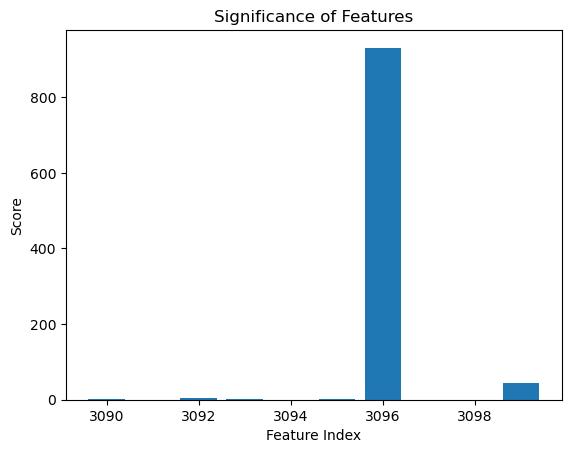

In [23]:
score = k_best.scores_
features = np.arange(x_data_fp.shape[1])

plt.bar(features[3090:3100], score[3090:3100])
plt.xlabel('Feature Index')
plt.ylabel('Score')
plt.title('Significance of Features')
plt.show()

# Outlist

In [3]:
out_list = []
for column in x_train_fp.columns:
    corr_tuple = pearsonr(x_train_fp[column], y_train_fp)
    out_list.append([column, corr_tuple[0], corr_tuple[1]])

C:\Users\oomsin\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


# Relationship of Features with Response Variables

In [5]:
def plot_join_plot(df, feature, target):
  j = sns.jointplot(data=df, x=feature, y=target, kind='reg')
  ax = j.ax_joint
  j.ax_joint.set_xlabel(f'Bit: {feature}')
  j.ax_joint.set_ylabel('Normal boiling point [K]')
  r, p = stats.pearsonr(df[feature], df[target])
  j.ax_joint.annotate(f'$\\rho = {r:.2f}, p = {p:.2f}$', xy=(0.1, 0.9), xycoords='axes fraction',ha='left', va='center',bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
  return plt.show()

In [6]:
train_df = pd.concat([x_train_fp, y_train_fp], axis=1)

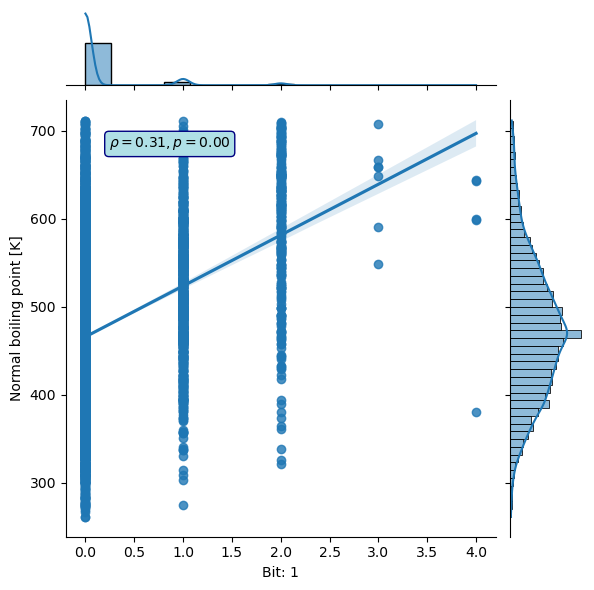

In [15]:
target_col = "Tb"
plot_join_plot(train_df, 1, target_col)

In [34]:
test = pd.concat([x_data_fp, y_data_fp], axis=1)
n_test = test[(test[1] == 4) * (test["Tb"] < 400)]
n_test

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,Tb
6570,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,380.15


# Correlation Analysis using Pearson Analysis

In [12]:
corr_df = pd.DataFrame(out_list, columns=["Features", "Correlation", "P-Value"])
corr_df.isnull().sum()

Features        0
Correlation    21
P-Value        21
dtype: int64

In [13]:
corr_df.sort_values(by=['P-Value'], inplace=True)
corr_df.dropna().round({'P-Value':3}).tail()

,Features,Correlation,P-Value
1275,1275,-0.000022,0.998
1813,1813,-0.000016,0.999
3685,3685,-0.000013,0.999
2256,2256,-0.000009,0.999
3903,3903,0.000003,1.000


In [82]:
#new_data = corr_df[corr_df["P-Value"] < 0.05]
new_data = corr_df["P-Value"].dropna()
new_data.round(3).head()

1       0.0
2       0.0
3096    0.0
3998    0.0
32      0.0
Name: P-Value, dtype: float64

In [10]:
new_features = []
for i in range(len(new_data["Features"])):
    new_features.append(i)
len(new_features)

NameError: name 'new_data' is not defined

In [ ]:
max(x_train_fp[1][:])

In [ ]:
x_train_fp.head()

## Score and P-Value

In [140]:
k_best = SelectKBest(f_regression, k=668) # Select the top 200 features
x_new = k_best.fit_transform(x_data_fp, y_data_fp)

scores = k_best.scores_
pvalues = k_best.pvalues_

selected_features = k_best.get_support()
feature_names = x_data_fp.columns
        
#Print the scores of the selected features
test = []
for i, feature_name in enumerate(feature_names):
    if selected_features[i]:
        test.append([feature_name, scores[i], pvalues[i]])
#        print(f"Feature {feature_name}: {scores[i]:.2f}")

In [25]:
n_df = pd.DataFrame(test, columns=["Features", "Score", "P-Value"])
n_df.sort_values(by=['Score'], ascending=False, inplace=False)

NameError: name 'test' is not defined

In [142]:
nn = n_df[(n_df["Score"] > 10) * (n_df["P-Value"] < 0.05)].sort_values(by=['Score'], ascending=False)
nn.shape

(531, 3)